# Image captioning with visual attention

## Creating Data Structure

In [1]:
!mkdir data
%cd data
!mkdir raw external processed
!mkdir processed/train processed/test

/content/data


In [2]:
!apt-get -qq install tree

Selecting previously unselected package tree.
(Reading database ... 144628 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [3]:
!tree .

.
├── external
├── processed
│   ├── test
│   └── train
└── raw

5 directories, 0 files


## Downloading Data



In [4]:
!wget -q http://13.234.225.243:9600/train_data.tar -O external/train_data.tar

In [5]:
!wget -q http://13.234.225.243:9600/test_data.tar -O external/test_data.tar 

In [6]:
!tar -xf external/train_data.tar -C raw/

In [7]:
!tar -xf external/test_data.tar -C raw/

In [8]:
!wget -q http://13.234.225.243:9600/train_data.csv -O raw/train_data/train_data.csv

In [9]:
!wget -q http://13.234.225.243:9600/sample_submission.csv -O raw/test_data/sample_submission.csv

### Utility Functions

In [10]:
import matplotlib.pyplot as plt
import tensorflow as tf


def plot_grid(files, labels=None, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    random_indexes = random.sample(range(len(files)), k=h*w)
    for i, j in enumerate(random_indexes):
        image = tf.io.read_file(files[j])
        image = tf.image.decode_jpeg(image, 3)
        image = tf.cast(image/255, tf.float32)
        label = labels[j]

        ax[i // h, i % w].imshow(image)
        ax[i // h, i % w].axis("off")
        ax[i // h, i % w].set_title(label)
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

## Extract DateField

In [11]:
from glob import glob

import cv2 as cv
import numpy as np
from tqdm import tqdm


class ExtractRectangle:
    def __init__(self):
        super().__init__()

        self.minLinLength_h = 70
        self.minLinLength_v = 5
        self.maxLineGap = 20

    def is_horizontal(self, line, thresh=5):
        return abs(line[1] - line[3]) <= thresh

    def is_vertical(self, line, thresh=5):
        return abs(line[0] - line[2]) <= thresh

    def get_lines(self, canny, horizontal=True):
        lines = []
        if horizontal:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_h,
                maxLineGap=20,
            )
        else:
            linesP = cv.HoughLinesP(
                canny,
                rho=1,
                theta=np.pi / 180,
                threshold=10,
                lines=None,
                minLineLength=self.minLinLength_v,
                maxLineGap=20,
            )
        if linesP is not None:
            for i in range(0, len(linesP)):
                l = linesP[i][0]
                if self.is_horizontal(l, 3) and horizontal:
                    lines.append(l)
                elif self.is_vertical(l, 3):
                    lines.append(l)
        return lines

    def remove_whitespace(self, img):
        # https://stackoverflow.com/questions/48395434/how-to-crop-or-remove-white-background-from-an-image
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        th, threshed = cv.threshold(gray, 127, 255, cv.THRESH_BINARY_INV)

        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
        morphed = cv.morphologyEx(threshed, cv.MORPH_CLOSE, kernel)

        cnts = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2]
        cnt = sorted(cnts, key=cv.contourArea)[-1]

        x, y, w, h = cv.boundingRect(cnt)
        dst = img[y : y + h, x : x + w]
        return dst

    def process_image(self, filename, path):
        errenous = False
        img = cv.imread(cv.samples.findFile(filename))
        img = self.remove_whitespace(img)
        cImage = np.copy(img)

        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        canny = cv.Canny(gray, 100, 200)

        horizontal_lines = self.get_lines(canny)
        horizontal_lines = sorted(horizontal_lines, key=lambda a_entry: a_entry[..., 1])

        vertical_lines = self.get_lines(canny, horizontal=False)
        vertical_lines = sorted(vertical_lines, key=lambda a_entry: a_entry[..., 0])

        if len(horizontal_lines) > 0:
            initial_line = horizontal_lines[0]
            final_line = horizontal_lines[-1]

            # LeftTop(x1, y1) -> RightTop(x2, y1) -> RightBottom(x2, y2) -> LeftBottom(x1, y2)
            y1 = initial_line[1]
            y2 = final_line[1]
            bottom = min(y1, y2)
            top = max(y1, y2)

            # post whitespace removal, dates should only be the major component
            if (top - bottom) / img.shape[0] < 0.6:
                errenous = True
        else:
            errenous = True

        if len(vertical_lines) > 0:
            initial_line = vertical_lines[0]
            final_line = vertical_lines[-1]

            x1 = initial_line[0]
            x2 = final_line[0]
            left = min(x1, x2)
            right = max(x1, x2)

            # as dates occupy majority of the horizontal space
            if (right - left) / img.shape[1] < 0.9:
                errenous = True
        else:
            errenous = True

        if not errenous:
            # cImage = cv.rectangle(cImage, (left, bottom), (right, top), (255, 0, 0), 2)
            cImage = cImage[
                bottom : bottom + (top - bottom), left : left + (right - left)
            ]
        cv.imwrite(f"{path}/{filename.split('/')[-1]}", cImage)

In [12]:
extract = ExtractRectangle()
test_files = glob("raw/test_data/*.png")
test_path = "processed/test/"
for path in tqdm(test_files):
    extract.process_image(path, test_path)

train_files = glob("raw/train_data/*.png")
train_path = "processed/train/"
for path in tqdm(train_files):
    extract.process_image(path, train_path)

100%|██████████| 10000/10000 [01:37<00:00, 102.24it/s]


## Image Captioning

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
import collections
import json
import os
import pickle
from pprint import pprint
import random
import requests
import re
import time
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm

In [15]:
TEST_IMAGES_PATH = "processed/test/"
TRAIN_CSV_PATH = "raw/train_data/train_data.csv"
TRAIN_IMAGES_PATH = "processed/train/"
RANDOM_STATE = 42
BATCH_SIZE = 64

In [16]:
PUBLIC_host = "http://13.234.225.243"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"
DATA_URL = PUBLIC_host + ":9600"
TAG = "image_captioning_v1"

In [17]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"


seed_everything(RANDOM_STATE)

### Prepare Dataset

In [18]:
train_df = pd.read_csv(TRAIN_CSV_PATH).sort_values(by="tag")

In [19]:
train_df["length"] = train_df["label"].astype(str).str.len()

In [20]:
train_df = train_df.loc[train_df["length"]==8]

In [21]:
image_paths = train_df["tag"].apply(lambda x: TRAIN_IMAGES_PATH+f"{x}.png").tolist()
labels = train_df["label"].apply(lambda x: f"<start> {' '.join(str(x))} <end>").tolist()

In [22]:
orig_labels = train_df["label"].astype(str).tolist()

In [23]:
len(image_paths), len(labels)

(9020, 9020)

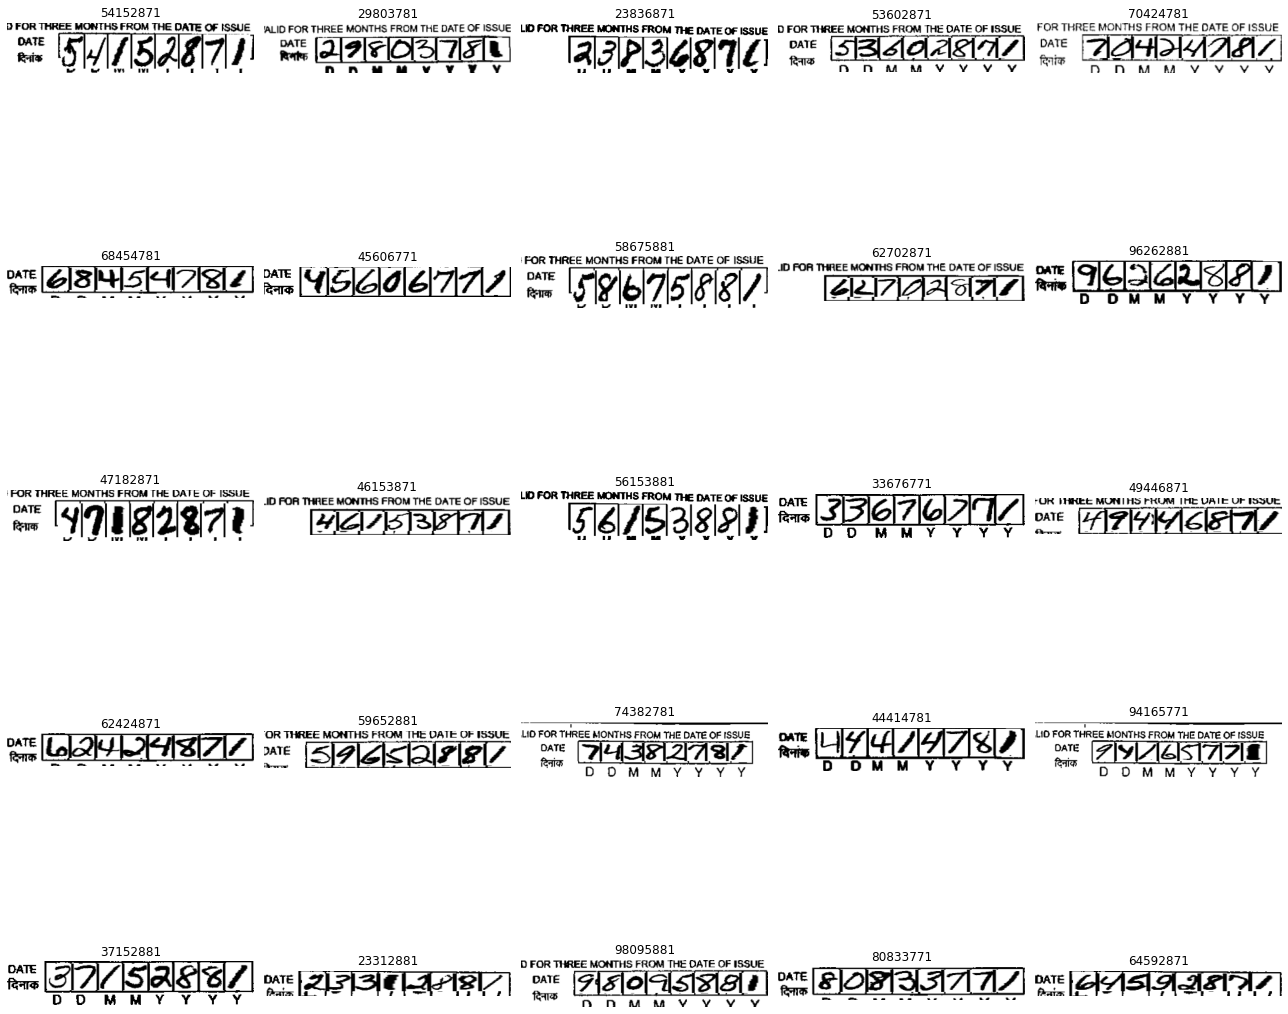

In [24]:
plot_grid(image_paths, orig_labels)

### Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [25]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [26]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


### Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk.

In [27]:
encode_train = sorted(set(image_paths))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE
).batch(BATCH_SIZE)

for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(
        batch_features, (batch_features.shape[0], -1, batch_features.shape[3])
    )

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 141/141 [01:42<00:00,  1.38it/s]


### Preprocess and tokenize the captions

In [28]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [29]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(labels)
train_seqs = tokenizer.texts_to_sequences(labels)

In [30]:
train_seqs = tokenizer.texts_to_sequences(labels)

In [31]:
max_length = calc_max_length(train_seqs)

### Split the data into training and testing

In [32]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(image_paths, train_seqs):
    img_to_cap_vector[img].append(cap)

img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
    capv_len = len(img_to_cap_vector[imgv])
    img_name_val.extend([imgv] * capv_len)
    cap_val.extend(img_to_cap_vector[imgv])

In [33]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(7216, 7216, 1804, 1804)

### Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [34]:
BUFFER_SIZE = 1000
EMBED_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.word_index)+1
EPOCHS = 25
NUM_STEPS = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [35]:
# Load the numpy files
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode("utf-8") + ".npy")
    return img_tensor, cap

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(
    lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]
    ),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [37]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)
        )

        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)

        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [38]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [39]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(
            self.units,
            return_sequences=True,
            return_state=True,
            recurrent_initializer="glorot_uniform",
        )
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [40]:
encoder = CNN_Encoder(EMBED_DIM)
decoder = RNN_Decoder(EMBED_DIM, UNITS, VOCAB_SIZE)

In [41]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoint

In [42]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

### Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [44]:
loss_plot = []

In [45]:
@tf.function
def train_step(img_tensor, target):
    loss = 0

    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = loss / int(target.shape[1])

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [46]:
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 200 == 0:
            print(
                "Epoch {} Batch {} Loss {:.4f}".format(
                    epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])
                )
            )
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / NUM_STEPS)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print("Epoch {} Loss {:.6f}".format(epoch + 1, total_loss / NUM_STEPS))
    print("Time taken for 1 epoch {} sec\n".format(time.time() - start))

Epoch 1 Batch 0 Loss 2.3693
Epoch 1 Loss 1.667200
Time taken for 1 epoch 61.35946345329285 sec

Epoch 2 Batch 0 Loss 1.4616
Epoch 2 Loss 1.434123
Time taken for 1 epoch 34.582574129104614 sec

Epoch 3 Batch 0 Loss 1.4210
Epoch 3 Loss 1.225443
Time taken for 1 epoch 7.337721824645996 sec

Epoch 4 Batch 0 Loss 1.0529
Epoch 4 Loss 0.966218
Time taken for 1 epoch 7.31969690322876 sec

Epoch 5 Batch 0 Loss 0.8858
Epoch 5 Loss 0.869857
Time taken for 1 epoch 7.316494703292847 sec

Epoch 6 Batch 0 Loss 0.8051
Epoch 6 Loss 0.773206
Time taken for 1 epoch 7.417107105255127 sec

Epoch 7 Batch 0 Loss 0.6946
Epoch 7 Loss 0.710381
Time taken for 1 epoch 7.3252129554748535 sec

Epoch 8 Batch 0 Loss 0.6921
Epoch 8 Loss 0.667143
Time taken for 1 epoch 7.357875823974609 sec

Epoch 9 Batch 0 Loss 0.6431
Epoch 9 Loss 0.625106
Time taken for 1 epoch 7.384549140930176 sec

Epoch 10 Batch 0 Loss 0.5816
Epoch 10 Loss 0.574056
Time taken for 1 epoch 7.342511415481567 sec

Epoch 11 Batch 0 Loss 0.5914
Epoch 11

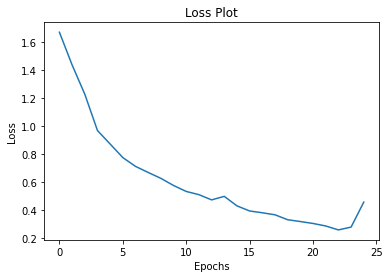

In [47]:
plt.plot(loss_plot)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Plot")
plt.show()

## Evaluation

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [48]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3])
    )

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index["<start>"]], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1,)).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == "<end>":
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[: len(result), :]
    return result, attention_plot

In [49]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result // 2, len_result // 2, l + 1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap="gray", alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> 2 4 2 4 5 8 7 1 <end>
Prediction Caption: 2 6 2 4 3 8 7 1 <end>


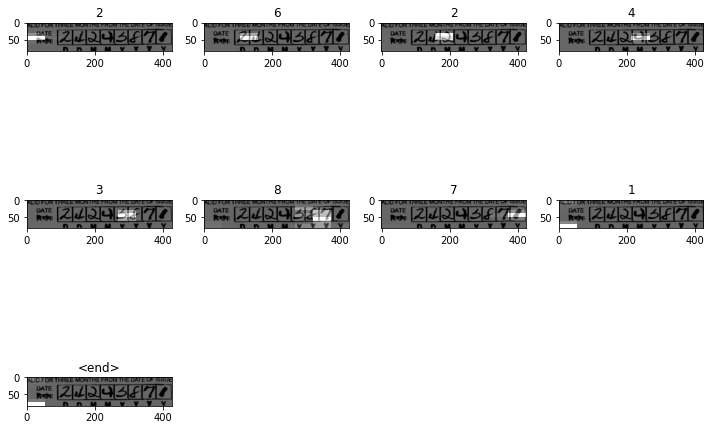

Real Caption: <start> 5 0 3 8 5 8 7 1 <end>
Prediction Caption: 3 0 2 1 3 8 7 1 <end>


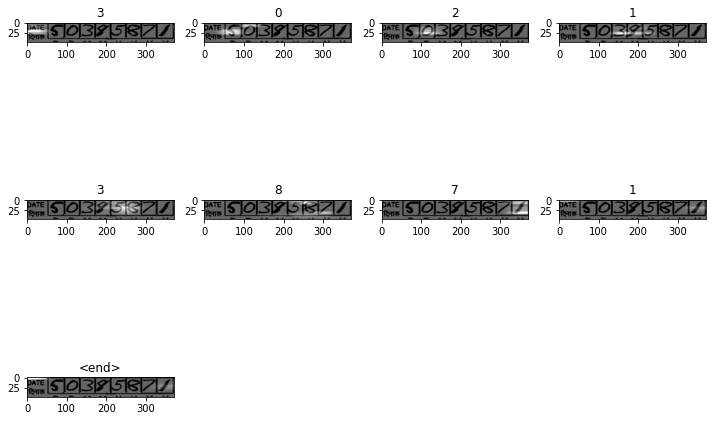

Real Caption: <start> 9 1 3 6 2 7 7 1 <end>
Prediction Caption: 9 1 9 2 2 7 7 1 <end>


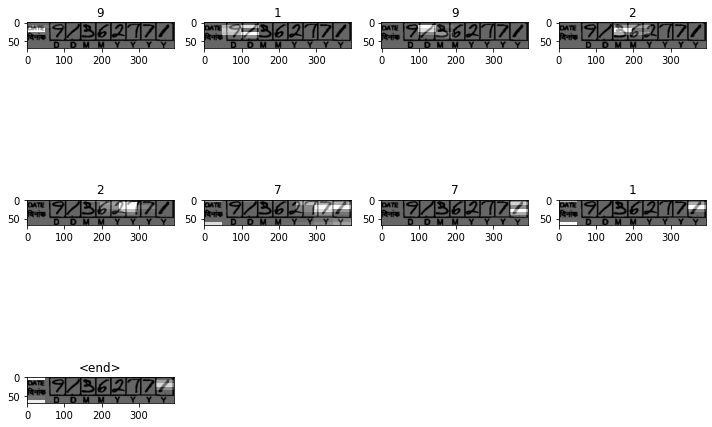

Real Caption: <start> 6 0 0 5 6 7 8 1 <end>
Prediction Caption: 6 0 0 0 5 7 8 1 <end>


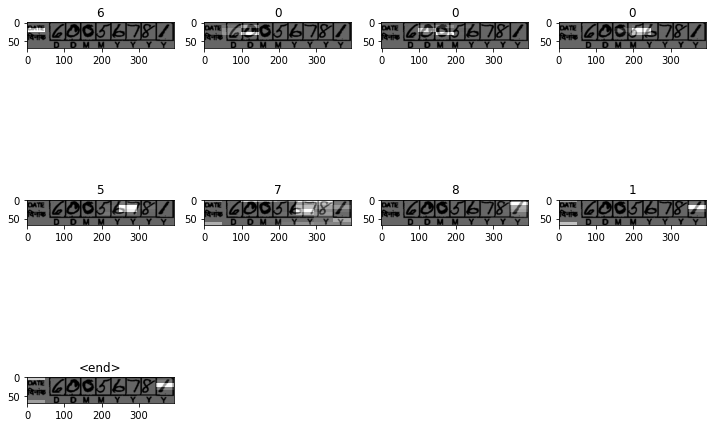

Real Caption: <start> 7 7 1 7 2 7 7 1 <end>
Prediction Caption: 7 7 1 1 2 7 7 1 <end>


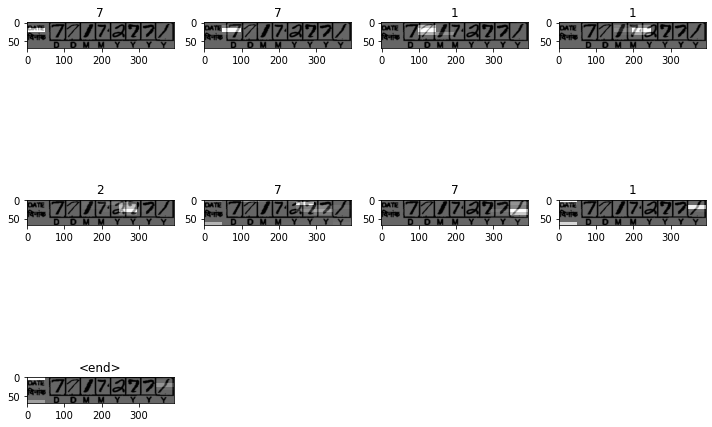

In [50]:
# captions on the validation set
for _ in range(5):
    rid = np.random.randint(0, 100)
    image = img_name_val[rid]
    real_caption = " ".join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
    result, attention_plot = evaluate(image)

    print("Real Caption:", real_caption)
    print("Prediction Caption:", " ".join(result))
    plot_attention(image, result, attention_plot)

### Validation Data Evaluation

In [51]:
count = 0
val_preds, val_matches = [], []

for idx in tqdm(range(len(img_name_val))):
    result, _ = evaluate(img_name_val[idx])
    result = "".join(result[:-1])
    label = "".join([tokenizer.index_word[i] for i in cap_val[idx][1:-1] if i not in [0]])
    val_preds.append(result)

    if len(result) < 8:
        count += 1
        print(f"Image: {img_name_val[idx].split('/')[-1]}\tLabel: {label}\tResult: {result}")
    else:
        digit_matches = {}
        for j in range(8):
            digit_matches[j] = result[j]==label[j]
        val_matches.append(digit_matches)

  0%|          | 8/1804 [00:01<04:22,  6.85it/s]

Image: 1451.png	Label: 39713771	Result: 8715771


  4%|▍         | 80/1804 [00:12<04:17,  6.68it/s]

Image: 9615.png	Label: 84682771	Result: 4268771


  6%|▌         | 111/1804 [00:16<04:12,  6.70it/s]

Image: 6405.png	Label: 57855771	Result: 5755771


  9%|▊         | 155/1804 [00:23<04:08,  6.63it/s]

Image: 328.png	Label: 75872771	Result: 7595771


  9%|▉         | 160/1804 [00:24<04:03,  6.76it/s]

Image: 8434.png	Label: 35136871	Result: 5626871


 10%|▉         | 174/1804 [00:26<03:48,  7.14it/s]

Image: 9900.png	Label: 16735771	Result: 1


 14%|█▍        | 254/1804 [00:38<03:49,  6.76it/s]

Image: 6422.png	Label: 13114771	Result: 1116771


 14%|█▍        | 259/1804 [00:39<03:51,  6.67it/s]

Image: 9221.png	Label: 25685881	Result: 2308881


 28%|██▊       | 500/1804 [01:15<03:11,  6.81it/s]

Image: 657.png	Label: 15354781	Result: 3734781


 41%|████      | 735/1804 [01:50<02:44,  6.48it/s]

Image: 9094.png	Label: 94226781	Result: 9222881


 52%|█████▏    | 934/1804 [02:20<02:08,  6.78it/s]

Image: 3700.png	Label: 49134771	Result: 4214771


 59%|█████▊    | 1058/1804 [02:38<01:51,  6.70it/s]

Image: 7907.png	Label: 84274781	Result: 8892781


 61%|██████    | 1103/1804 [02:45<01:43,  6.77it/s]

Image: 580.png	Label: 76623781	Result: 2626781


 62%|██████▏   | 1121/1804 [02:47<01:40,  6.82it/s]

Image: 7771.png	Label: 72604771	Result: 7202771


 66%|██████▌   | 1189/1804 [02:57<01:28,  6.92it/s]

Image: 7319.png	Label: 12186771	Result: 3136771


 70%|██████▉   | 1258/1804 [03:08<01:19,  6.90it/s]

Image: 2954.png	Label: 87064781	Result: 8676771


 78%|███████▊  | 1405/1804 [03:29<00:57,  6.88it/s]

Image: 5840.png	Label: 78333871	Result: 7833781


100%|██████████| 1804/1804 [04:29<00:00,  6.70it/s]


In [52]:
val_matches[0]

{0: True, 1: False, 2: False, 3: False, 4: False, 5: True, 6: True, 7: True}

In [53]:
result_df = pd.DataFrame(val_matches)
valid_res = pd.DataFrame()
valid_res["# Positionwise Correct Preds"] = result_df.sum()
valid_res["% Positionwise Accuracy"] = result_df.sum()/len(result_df)*100

In [54]:
valid_res

,# Positionwise Correct Preds,% Positionwise Accuracy
0,1231,68.886402
1,780,43.648573
2,728,40.738668
3,712,39.843313
4,1037,58.030218
5,1466,82.036933
6,1584,88.640179
7,1773,99.216564


**The entire training data has either [771, 781, 871, 881] as the last 3 digit. On the other hand this is not the case with testing data. Refer my [exploration notebook](initial_exploration.ipynb)**

### Entire Training Data Evaluation

In [55]:
count = 0
train_preds, train_matches, train_mismatches = [], [], []
for path, label in tqdm(dict(zip(image_paths, orig_labels)).items()):
    try:
        result, attention_plot = evaluate(path)
        result = "".join(result[:-1])
        train_preds.append(result)

        if len(result) < 8:
            count += 1
            train_mismatches.append({path: result})
            print(f"Image: {path.split('/')[-1]}\tLabel: {label}\tResult: {result}")
        else:
            digit_matches = {}
            for j in range(8):
                digit_matches[j] = result[j]==label[j]
            train_matches.append(digit_matches)
    except Exception:
        count += 1

  1%|          | 101/9020 [00:15<22:18,  6.66it/s]

Image: 105.png	Label: 53433881	Result: 5334881


  4%|▎         | 324/9020 [00:49<21:14,  6.82it/s]

Image: 342.png	Label: 52704771	Result: 5674771


  4%|▍         | 371/9020 [00:56<21:54,  6.58it/s]

Image: 398.png	Label: 10073881	Result: 1107881


  5%|▍         | 409/9020 [01:02<21:25,  6.70it/s]

Image: 439.png	Label: 98762771	Result: 4736771


  6%|▌         | 536/9020 [01:21<21:18,  6.64it/s]

Image: 580.png	Label: 76623781	Result: 2864781


  7%|▋         | 604/9020 [01:31<20:45,  6.76it/s]

Image: 657.png	Label: 15354781	Result: 5733781


  9%|▉         | 794/9020 [02:00<20:01,  6.85it/s]

Image: 858.png	Label: 35126781	Result: 8365781


 10%|█         | 908/9020 [02:17<20:25,  6.62it/s]

Image: 988.png	Label: 20173771	Result: 2013771


 12%|█▏        | 1055/9020 [02:40<19:44,  6.73it/s]

Image: 1155.png	Label: 26275771	Result: 2627771


 14%|█▎        | 1220/9020 [03:04<18:48,  6.91it/s]

Image: 1335.png	Label: 99613771	Result: 996171


 15%|█▍        | 1331/9020 [03:21<19:03,  6.73it/s]

Image: 1451.png	Label: 39713771	Result: 8722771


 17%|█▋        | 1526/9020 [03:50<18:24,  6.78it/s]

Image: 1671.png	Label: 57493771	Result: 8789771


 18%|█▊        | 1590/9020 [04:00<18:47,  6.59it/s]

Image: 1741.png	Label: 82315771	Result: 8382771


 19%|█▉        | 1693/9020 [04:15<18:14,  6.69it/s]

Image: 1856.png	Label: 33384781	Result: 3234781


 20%|██        | 1804/9020 [04:32<17:25,  6.90it/s]

Image: 1983.png	Label: 82054771	Result: 82031


 22%|██▏       | 1980/9020 [04:58<17:51,  6.57it/s]

Image: 2175.png	Label: 75353871	Result: 7535871


 25%|██▍       | 2248/9020 [05:39<15:40,  7.20it/s]

Image: 2472.png	Label: 15154871	Result: 6141


 25%|██▌       | 2296/9020 [05:46<16:15,  6.89it/s]

Image: 2526.png	Label: 38204781	Result: 58204


 26%|██▌       | 2360/9020 [05:56<15:37,  7.10it/s]

Image: 2594.png	Label: 61084871	Result: 6101


 30%|██▉       | 2685/9020 [06:44<15:30,  6.80it/s]

Image: 2954.png	Label: 87064781	Result: 8466781


 30%|██▉       | 2694/9020 [06:45<15:13,  6.92it/s]

Image: 2965.png	Label: 96332771	Result: 9633771


 31%|███       | 2769/9020 [06:56<15:02,  6.93it/s]

Image: 3049.png	Label: 15394771	Result: 1334771


 31%|███       | 2794/9020 [07:00<15:10,  6.84it/s]

Image: 3077.png	Label: 66433771	Result: 6433781


 32%|███▏      | 2913/9020 [07:18<14:47,  6.88it/s]

Image: 3211.png	Label: 80382771	Result: 8282771


 37%|███▋      | 3360/9020 [08:26<14:08,  6.67it/s]

Image: 3700.png	Label: 49134771	Result: 4194771


 43%|████▎     | 3852/9020 [09:41<13:20,  6.46it/s]

Image: 4250.png	Label: 70382781	Result: 9852781


 44%|████▎     | 3931/9020 [09:53<12:40,  6.69it/s]

Image: 4332.png	Label: 77875781	Result: 1594781


 44%|████▍     | 3963/9020 [09:58<12:35,  6.70it/s]

Image: 4368.png	Label: 89933881	Result: 4893881


 44%|████▍     | 3979/9020 [10:01<12:44,  6.60it/s]

Image: 4385.png	Label: 51635881	Result: 2125881


 46%|████▋     | 4182/9020 [10:32<12:11,  6.61it/s]

Image: 4615.png	Label: 55174881	Result: 5181


 54%|█████▎    | 4845/9020 [12:13<09:49,  7.08it/s]

Image: 5355.png	Label: 84215771	Result: 8621


 56%|█████▌    | 5018/9020 [12:39<09:15,  7.21it/s]

Image: 5546.png	Label: 95162781	Result: 971


 59%|█████▊    | 5281/9020 [13:19<09:12,  6.76it/s]

Image: 5840.png	Label: 78333871	Result: 7853871


 59%|█████▉    | 5329/9020 [13:26<09:05,  6.77it/s]

Image: 5893.png	Label: 42652781	Result: 4365781


 59%|█████▉    | 5364/9020 [13:31<09:03,  6.73it/s]

Image: 5933.png	Label: 65264771	Result: 6524771


 60%|█████▉    | 5379/9020 [13:34<08:55,  6.80it/s]

Image: 5950.png	Label: 17703781	Result: 1576781


 63%|██████▎   | 5669/9020 [14:17<08:08,  6.86it/s]

Image: 6270.png	Label: 64123871	Result: 6412881


 64%|██████▍   | 5779/9020 [14:33<07:29,  7.22it/s]

Image: 6385.png	Label: 20115781	Result: 401


 66%|██████▌   | 5952/9020 [14:59<07:28,  6.84it/s]

Image: 6572.png	Label: 69345871	Result: 6953871


 66%|██████▋   | 5985/9020 [15:04<07:24,  6.83it/s]

Image: 6607.png	Label: 15184781	Result: 151427


 66%|██████▋   | 5997/9020 [15:06<07:27,  6.76it/s]

Image: 6619.png	Label: 10285771	Result: 1028771


 67%|██████▋   | 6082/9020 [15:18<07:11,  6.81it/s]

Image: 6713.png	Label: 81322781	Result: 2832781


 69%|██████▊   | 6187/9020 [15:34<07:17,  6.47it/s]

Image: 6826.png	Label: 50102781	Result: 5605771


 73%|███████▎  | 6627/9020 [16:40<05:51,  6.81it/s]

Image: 7319.png	Label: 12186771	Result: 1346771


 75%|███████▍  | 6743/9020 [16:57<05:32,  6.85it/s]

Image: 7454.png	Label: 11072871	Result: 1107881


 75%|███████▍  | 6746/9020 [16:58<05:33,  6.83it/s]

Image: 7457.png	Label: 65024871	Result: 6252881


 75%|███████▌  | 6799/9020 [17:06<05:32,  6.67it/s]

Image: 7516.png	Label: 81985781	Result: 1136781


 78%|███████▊  | 6995/9020 [17:35<04:57,  6.81it/s]

Image: 7737.png	Label: 63466771	Result: 6366771


 79%|███████▉  | 7143/9020 [17:57<04:37,  6.76it/s]

Image: 7907.png	Label: 84274781	Result: 8284771


 82%|████████▏ | 7355/9020 [18:29<04:04,  6.82it/s]

Image: 8148.png	Label: 88735781	Result: 8875781


 84%|████████▍ | 7602/9020 [19:06<03:32,  6.67it/s]

Image: 8412.png	Label: 26533781	Result: 6543781


 85%|████████▍ | 7622/9020 [19:09<03:23,  6.88it/s]

Image: 8434.png	Label: 35136871	Result: 5636871


 85%|████████▌ | 7703/9020 [19:21<03:14,  6.78it/s]

Image: 8524.png	Label: 99425881	Result: 9642881


 87%|████████▋ | 7889/9020 [19:49<02:49,  6.69it/s]

Image: 8732.png	Label: 80744881	Result: 8074881


 91%|█████████ | 8179/9020 [20:31<01:58,  7.10it/s]

Image: 9053.png	Label: 35235871	Result: 3235881


 91%|█████████ | 8216/9020 [20:37<01:56,  6.90it/s]

Image: 9094.png	Label: 94226781	Result: 9222881


 95%|█████████▍| 8561/9020 [21:28<01:04,  7.09it/s]

Image: 9489.png	Label: 71966781	Result: 71791


 95%|█████████▌| 8586/9020 [21:32<01:03,  6.85it/s]

Image: 9519.png	Label: 94224771	Result: 9442771


 95%|█████████▌| 8606/9020 [21:35<01:00,  6.85it/s]

Image: 9542.png	Label: 32364771	Result: 3236771


 98%|█████████▊| 8834/9020 [22:08<00:26,  7.08it/s]

Image: 9791.png	Label: 47165781	Result: 41461


 98%|█████████▊| 8836/9020 [22:09<00:26,  7.05it/s]

Image: 9793.png	Label: 37483781	Result: 7385781


 98%|█████████▊| 8872/9020 [22:14<00:21,  6.94it/s]

Image: 9832.png	Label: 25594781	Result: 2534781


 99%|█████████▊| 8886/9020 [22:16<00:19,  6.79it/s]

Image: 9848.png	Label: 14634771	Result: 1163771


100%|██████████| 9020/9020 [22:36<00:00,  6.65it/s]


In [56]:
result_df = pd.DataFrame(train_matches)
train_res = pd.DataFrame()
train_res["# Positionwise Correct Preds"] = result_df.sum()
train_res["% Positionwise Accuracy"] = result_df.sum()/len(result_df)*100

### Test Data Prediction

In [57]:
test_image_paths = [f"processed/test/{x}.png" for x in range(1000)]

In [58]:
# prediction on test set
preds = []
for path in tqdm(test_image_paths):
    result, _ = evaluate(path)
    result = "".join(result[:-1])
    preds.append(result)

100%|██████████| 1000/1000 [02:26<00:00,  6.82it/s]


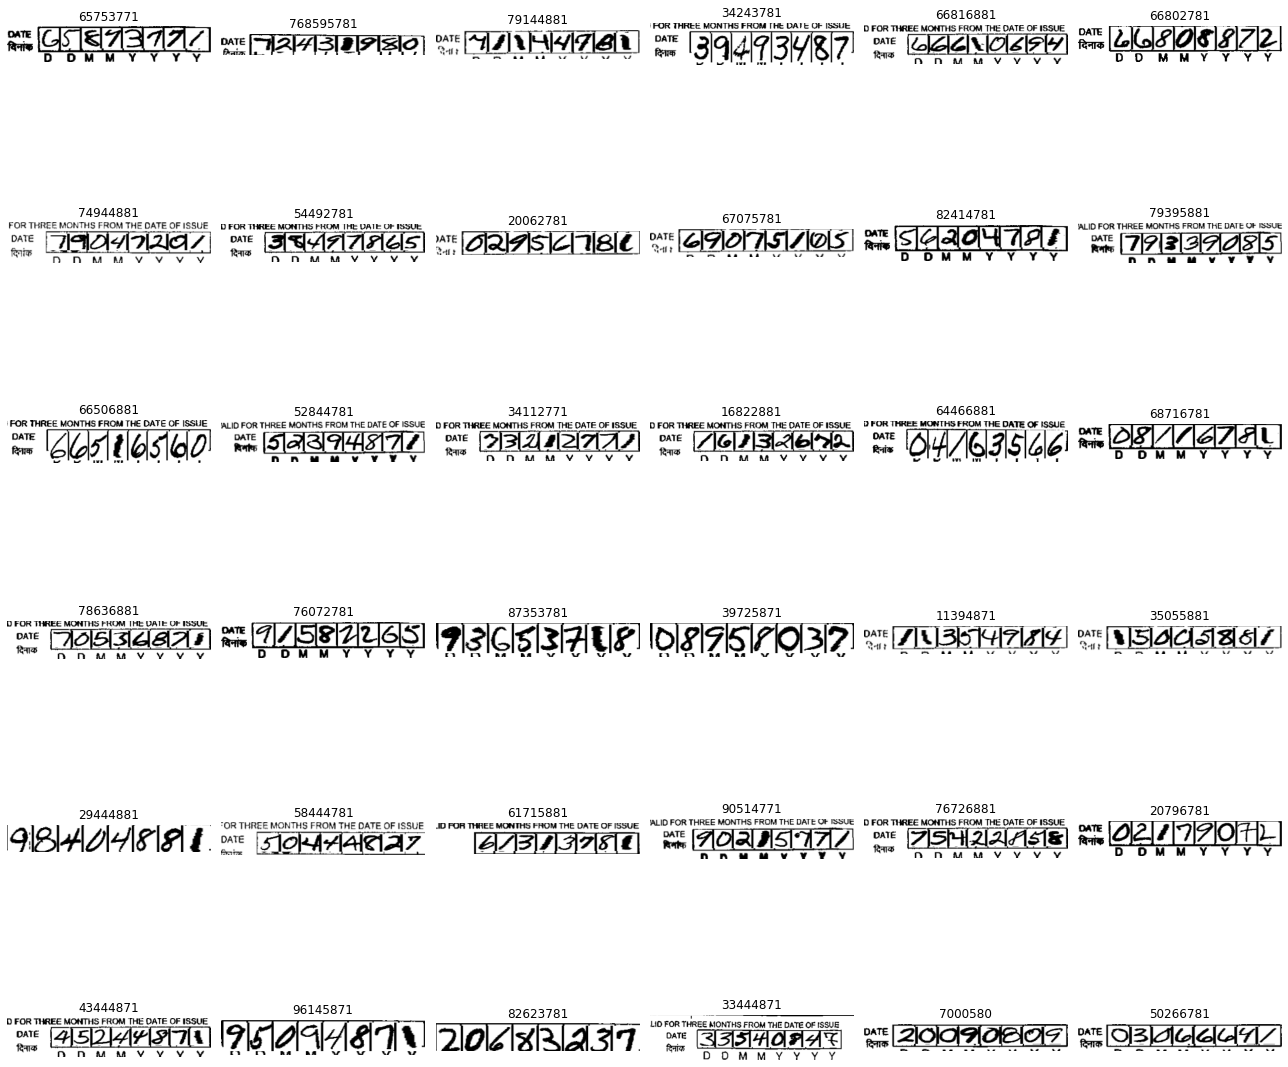

In [59]:
plot_grid(test_image_paths, preds, h=6, w=6)

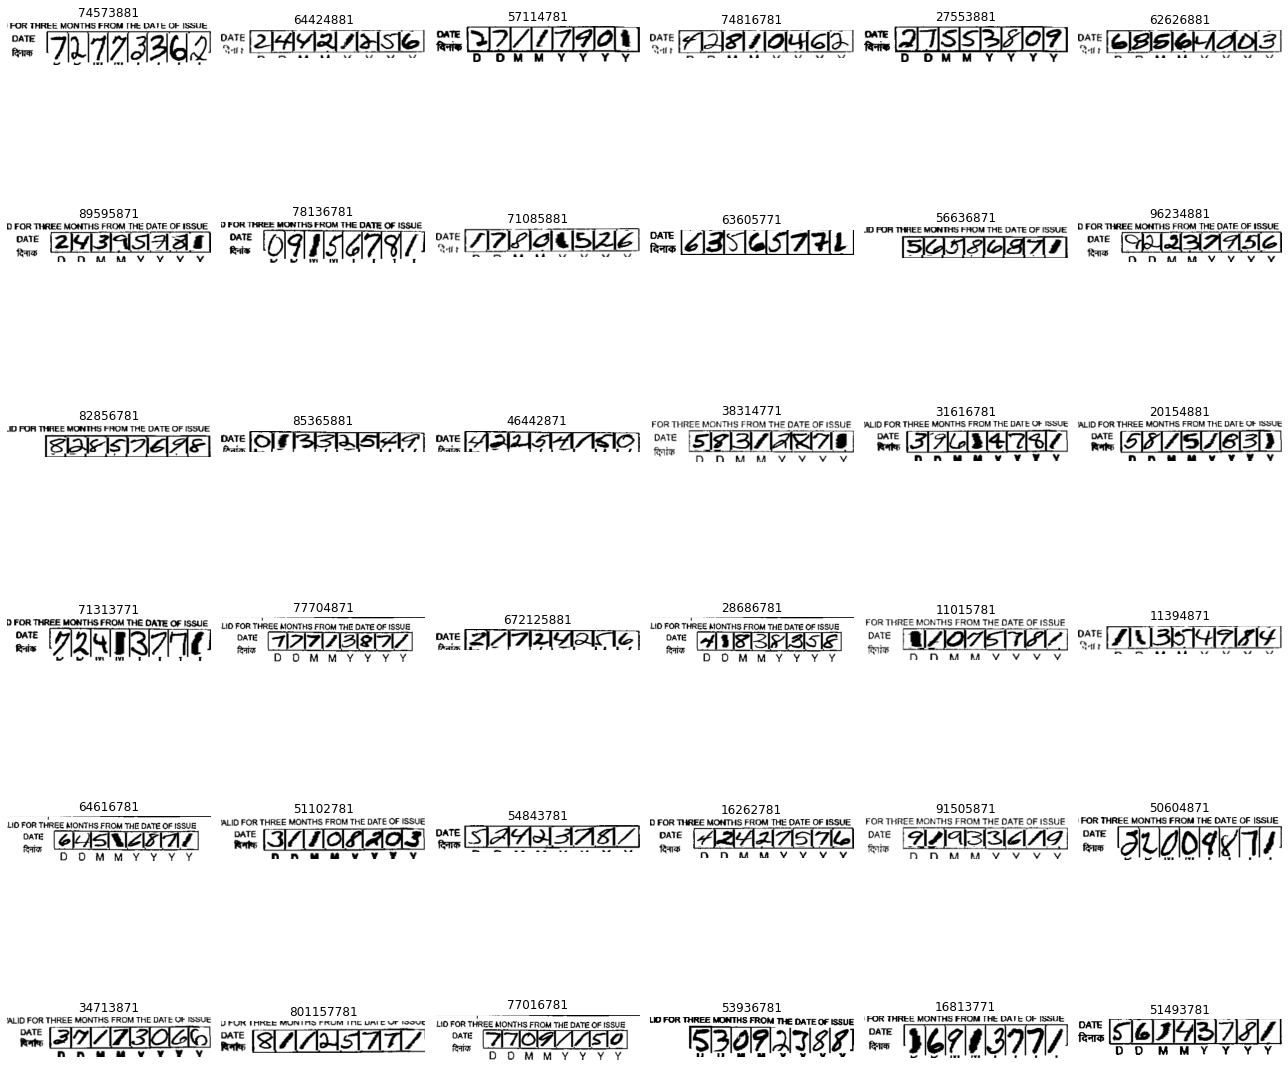

In [60]:
plot_grid(test_image_paths, preds, h=6, w=6)

In [61]:
sub_df = pd.DataFrame()
sub_df["tag"] = np.arange(0, 1000)
sub_df["label"] = preds
sub_df.to_csv(f"submission_image_captioning.csv", index=False)

In [62]:
sub_df.head()

,tag,label
0,0,99085871
1,1,77143781
2,2,71702881
3,3,67742881
4,4,85952781


In [63]:
sample = pd.read_csv("raw/test_data/sample_submission.csv")

In [64]:
sub_df = sub_df.set_index("tag")
sub_df = sub_df.reindex(index=sample["tag"])
sub_df = sub_df.reset_index()

In [65]:
sub_df.head()

,tag,label
0,667,19342881
1,733,93576781
2,530,80705781
3,779,64883871
4,775,16064871


In [68]:
sub_json = sub_df.to_json()
data = {
    "username": "aditya",
    "password": "sdhjbj@8676",
    "submission": sub_json,
    "tag": "aditya_v3",
}
r = requests.post(SUBMISSION_URL, json=data)

In [69]:
r.text

'{"success":true,"score":0.006}'

In [70]:
rl = requests.post(LEADERBOARD_URL, json={})
pprint(rl.json())

{'leaderboard': [{'score': 0.362,
                  'submitted_at': '2020-10-30-12-30-1604061007',
                  'tag': 'raj_test3',
                  'username': 'raj'},
                 {'score': 0.362,
                  'submitted_at': '2020-10-30-12-39-1604061549',
                  'tag': 'raj_test4',
                  'username': 'raj'},
                 {'score': 0.189,
                  'submitted_at': '2020-10-30-13-05-1604063139',
                  'tag': 'raj_test5',
                  'username': 'raj'},
                 {'score': 0.189,
                  'submitted_at': '2020-10-30-13-23-1604064186',
                  'tag': 'raj_test6',
                  'username': 'raj'},
                 {'score': 0.019,
                  'submitted_at': '2020-10-30-18-46-1604083586',
                  'tag': 'aditya_v1',
                  'username': 'aditya'},
                 {'score': 0.019,
                  'submitted_at': '2020-10-30-18-56-1604084186',
                  'tag'